In [8]:
import arviz as az 
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
import pymc_extras as pmx

from pymc_marketing import clv

### Load data

In [9]:
url_cdnow = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/cdnow_transactions.csv"

raw_data = pd.read_csv(url_cdnow)

### RFM aggregations

In [10]:
rfm_data = clv.rfm_summary(
    raw_data,
    customer_id_col="id",
    datetime_col="date",
    datetime_format="%Y%m%d",
    time_unit="W",
)

rfm_data.info()
rfm_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2357 entries, 0 to 2356
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  2357 non-null   int64  
 1   frequency    2357 non-null   float64
 2   recency      2357 non-null   float64
 3   T            2357 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 73.8 KB


,customer_id,frequency,recency,T
0,1,3.0,49.0,78.0
1,2,1.0,2.0,78.0
2,3,0.0,0.0,78.0
3,4,0.0,0.0,78.0
4,5,0.0,0.0,78.0


## ParetoNBDModel

### MAP fit

In [11]:
pnbd_map = clv.ParetoNBDModel(data=rfm_data)
pnbd_map.build_model()  # required for prior predictive checks
pnbd_map

Pareto/NBD
            alpha ~ Weibull(2, 10)
             beta ~ Weibull(2, 10)
                r ~ Weibull(2, 1)
                s ~ Weibull(2, 1)
recency_frequency ~ ParetoNBD(r, alpha, s, beta, <constant>)

In [12]:
with pnbd_map.model:
    prior_idata = pm.sample_prior_predictive(random_seed=45, samples=1)

obs_freq = prior_idata.observed_data["recency_frequency"].sel(obs_var="frequency")
ppc_freq = prior_idata.prior_predictive["recency_frequency"].sel(obs_var="frequency")[
    0
][0]

Sampling: [alpha, beta, r, recency_frequency, s]


In [13]:
pnbd_map.fit()
map_fit = pnbd_map.fit_summary()  # save for plotting later

obs_freq = pnbd_map.idata.observed_data["recency_frequency"].sel(obs_var="frequency")
ppc_freq = pnbd_map.distribution_new_customer_recency_frequency(
    rfm_data,
    random_seed=42,
).sel(chain=0, draw=0, obs_var="frequency")


Output()

Sampling: [recency_frequency]


Output()

### DEMZ fit

In [14]:
pnbd_full = clv.ParetoNBDModel(data=rfm_data)
pnbd_full.fit(
    fit_method="demz", draws=3000, tune=2500, idata_kwargs={"log_likelihood": True}
)

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [alpha, beta, r, s]
/opt/homebrew/envs/pymc-marketing-dev/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/opt/homebrew/envs/pymc-marketing-dev/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 2_500 tune and 3_000 draw iterations (10_000 + 12_000 draws total) took 5 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> fit_data

In [15]:
pnbd_full.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,15.630,1.018,13.798,17.583,0.034,0.024,904.0,1539.0,1.0
beta,12.640,3.568,6.271,19.272,0.134,0.094,685.0,821.0,1.0
r,0.619,0.045,0.537,0.703,0.002,0.001,868.0,1392.0,1.0
s,0.430,0.060,0.331,0.552,0.002,0.002,683.0,1015.0,1.0


### ADVI fit

In [16]:
pnbd_advi = clv.ParetoNBDModel(data=rfm_data)
pnbd_advi.fit(
    fit_method="advi", draws=4000, tune=2500, idata_kwargs={"log_likelihood": True}
)

Output()

Finished [100%]: Average Loss = 16,525


Inference data with groups:
	> posterior
	> observed_data
	> fit_data

In [17]:
pnbd_advi.fit_summary()

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,14.639,2.575,9.998,19.346,0.040,0.029,4076.0,4047.0,NaN
beta,15.234,4.258,8.053,23.332,0.065,0.046,4207.0,3872.0,NaN
r,0.565,0.092,0.401,0.745,0.001,0.001,4021.0,3921.0,NaN
s,0.433,0.082,0.289,0.586,0.001,0.001,3741.0,3732.0,NaN


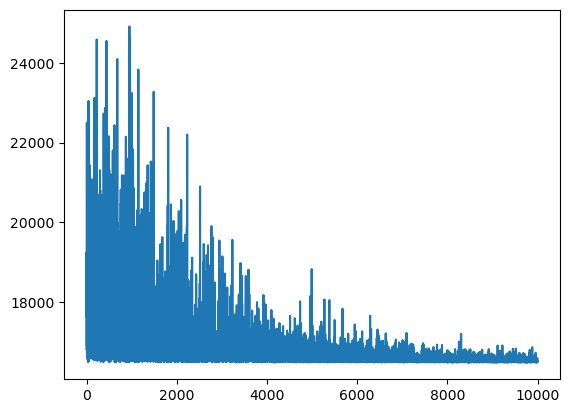

In [18]:
plt.plot(pnbd_advi.approx.hist)

### Full-rank fit

In [19]:
pnbd_fullrank = clv.ParetoNBDModel(data=rfm_data)
pnbd_fullrank.fit(
    fit_method="fullrank_advi", draws=4000, tune=2500, idata_kwargs={"log_likelihood": True}
)

Output()

Finished [100%]: Average Loss = 16,624


Inference data with groups:
	> posterior
	> observed_data
	> fit_data

In [20]:
pnbd_fullrank.fit_summary()

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,16.359,10.076,2.844,33.752,0.158,0.112,4050.0,3749.0,NaN
beta,21.681,25.035,0.630,57.741,0.397,0.281,3893.0,3923.0,NaN
r,0.651,0.417,0.120,1.420,0.007,0.005,4094.0,3832.0,NaN
s,0.493,0.382,0.055,1.153,0.006,0.004,3838.0,4003.0,NaN


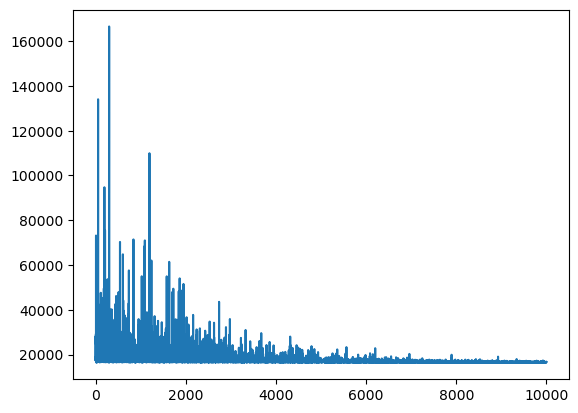

In [21]:
plt.plot(pnbd_fullrank.approx.hist)

## Visual comparison

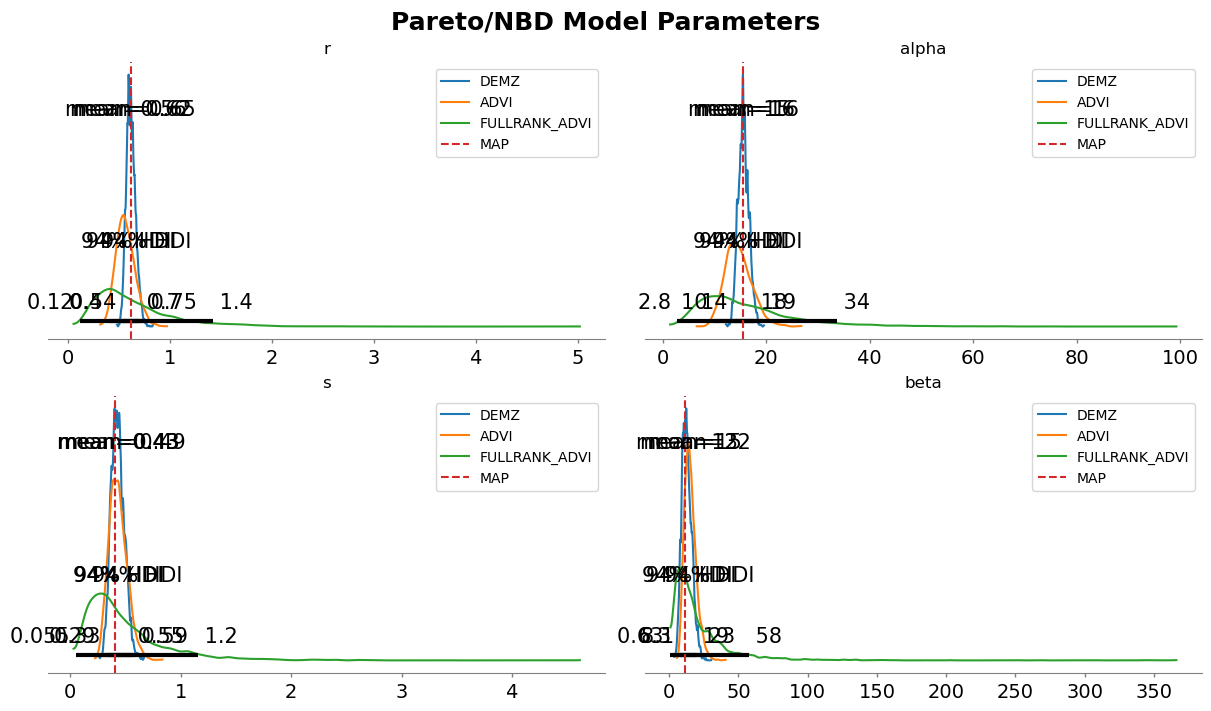

In [24]:
_, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 7), sharex=False, sharey=False, layout="constrained"
)

axes = axes.flatten()

for i, var_name in enumerate(["r", "alpha", "s", "beta"]):
    ax = axes[i]
    az.plot_posterior(
        pnbd_full.idata.posterior[var_name].values.flatten(),
        color="C0",
        point_estimate="mean",
        ax=ax,
        label="DEMZ",
    )
    az.plot_posterior(
        pnbd_advi.idata.posterior[var_name].values.flatten(),
        color="C1",
        point_estimate="mean",
        ax=ax,
        label="ADVI",
    )
    az.plot_posterior(
        pnbd_fullrank.idata.posterior[var_name].values.flatten(),
        color="C2",
        point_estimate="mean",
        ax=ax,
        label="FULLRANK_ADVI",
    )
    ax.axvline(x=map_fit[var_name], color="C3", linestyle="--", label="MAP")
    ax.legend(loc="upper right")
    ax.set_title(var_name)

plt.gcf().suptitle("Pareto/NBD Model Parameters", fontsize=18, fontweight="bold");

Observations:
- Fullrank provides a rather poor fit
- advi's fit does not match mcmc for r, alpha params
